В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score
#import torch.nn as nn

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [85]:
class NeuralNet:
   
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000, hidden_layer_sizes =(4,4), tol=1e-6, notimp_iters=200 ):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes =hidden_layer_sizes;
        #self.relu = nn.ReLU();
        self.tol =tol;
        self.num_layers =len(hidden_layer_sizes);
        self.notimp_iters = notimp_iters;
       # self.parameters=None
        
        
        
    
    def __normalize(self, X, mean = None, std = None):
    
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_arr):
        W_arr =[];
        b_arr =[];
       
        ######
        W1 = np.random.randn(n_arr[0], n_x)*0.01;
        b1 = np.zeros((n_arr[0], 1));
        W_arr.append(W1);
        b_arr.append(b1);
        
     
        for n_l in range(1,len(n_arr)):
            W_temp =np.random.randn(n_arr[n_l], n_arr[n_l-1]) * 0.01;
            b_temp = np.zeros((n_arr[n_l], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        
        
        W2 =np.random.randn(1, n_arr[len(n_arr)-1]) * 0.01
        b2 = 0;
        
        W_arr.append(W2);
        b_arr.append(b2);
        
        
        self.parameters = {"W_arr" : W_arr, "b_arr" : b_arr}
       
    def __forward_propagation(self, X):
        
        W_arr =self.parameters["W_arr"]
        b_arr = self.parameters["b_arr"]
        
        W1 = W_arr[0];
        b1 = b_arr[0];
        
        W2 =W_arr[len(W_arr)-1];
        b2 =b_arr[len(b_arr)-1];
        
        Z_arr =[];
        A_arr =[];
        
        Z1 =np.dot(W1,X)+b1;
        A1 = self.__sigmoid(Z1);
        
        
        Z_arr.append(Z1);
        A_arr.append(A1);
        
       
        for l in range(1,self.num_layers+1):
            Z_temp = np.dot(W_arr[l],A_arr[l-1])+b_arr[l];
            A_temp = self.__sigmoid(Z_temp);
            Z_arr.append(Z_temp);
            A_arr.append(A_temp);

        cache =(W_arr,b_arr,Z_arr,A_arr);
        
        return A_arr[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
 
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W_arr,b_arr,Z_arr,A_arr) = cache

        
        dZ_arr=[];
        dW_arr =[];
        dA_arr=[];
        db_arr =[];
        
        dZ2 = A_arr[-1] -Y;
        dW2 = 1. / m * np.dot(dZ2, A_arr[-2].T);
        db2 =1. / m * np.sum(dZ2, axis = 1, keepdims = True);
        dA2 =np.dot(W_arr[-1].T,dZ2);
        dZ_arr.insert(0,dZ2); 
        dW_arr.insert(0,dW2);
        db_arr.insert(0,db2);
        dA_arr.insert(0,dA2);
             
   
        for l_inv in range(len(W_arr)-2,0,-1):

            dZ_temp =np.multiply(dA_arr[0], np.multiply(A_arr[l_inv], 1 - A_arr[l_inv]));
            dW_temp =1. / m * np.dot(dZ_temp, A_arr[l_inv-1].T);
            db_temp =1. / m * np.sum(dZ_temp, axis = 1, keepdims = True);
            dA_temp =np.dot(W_arr[l_inv].T,dZ_temp);
            
            dZ_arr.insert(0,dZ_temp);
            dW_arr.insert(0,dW_temp);
            dA_arr.insert(0,dA_temp);
            db_arr.insert(0,db_temp);
        
       
        dA1 =dA_arr[0];
        dZ1 = np.multiply(dA1, np.multiply(A_arr[0], 1 - A_arr[0]));
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 =1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        
        dZ_arr.insert(0,dZ1); 
        dW_arr.insert(0,dW1);
        db_arr.insert(0,db1);
       
        grads ={"dZ_arr":dZ_arr,"dW_arr":dW_arr,"db_arr":db_arr}
        return grads
  
    
   
        
    def __update_parameters(self, grads):
            
        W_arr =self.parameters["W_arr"];
        b_arr =self.parameters["b_arr"];
        dW_arr =grads["dW_arr"];
        db_arr =grads["db_arr"];
        
        Wnew =W_arr.copy();
        bnew = b_arr.copy();
        for l in range(0,len(W_arr)):
            Wnew[l]-=self.learning_rate * dW_arr[l];
            bnew[l]-=self.learning_rate * db_arr[l];
        self.parameters["W_arr"] = Wnew;
        self.parameters["b_arr"] = bnew;
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        improve_costs =[]
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x,self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
                
            if i%self.notimp_iters ==0:
                improve_costs.append(cost);
                if len(improve_costs) >2:
                    if abs(improve_costs[len(improve_costs)-1] - improve_costs[len(improve_costs)-2]) < self.tol:
                        return;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [86]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


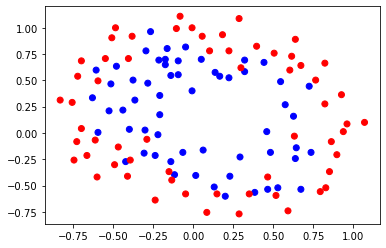

In [87]:
plot_data(X, Y)

In [88]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000)

In [89]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

0-th iteration: 0.6931985328093563


In [90]:
print(cls.parameters)

{'W_arr': [array([[ 0.01223743,  0.01024433],
       [-0.00120811, -0.01690645],
       [-0.03001014,  0.00238968],
       [-0.00389101, -0.01374607]]), array([[ 0.01461619, -0.00781578, -0.00443986, -0.01743256],
       [-0.00104105, -0.00589392, -0.01239372,  0.0025242 ],
       [ 0.01175995, -0.00810313,  0.00454764, -0.01045287],
       [-0.01385016, -0.00095544,  0.02374451, -0.00187903]]), array([[-0.00420909,  0.00032751, -0.01696409, -0.00732832]])], 'b_arr': [array([[ 2.86469620e-09],
       [ 2.55662480e-08],
       [-2.93005545e-07],
       [-3.70857327e-08]]), array([[-8.66996371e-06],
       [-3.11836475e-05],
       [ 5.59552497e-05],
       [ 1.22700644e-05]]), array([[-0.01981917]])]}


In [91]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.4915253 , 0.5084747 ],
       [0.49152532, 0.50847468],
       [0.49152526, 0.50847474],
       [0.49152532, 0.50847468],
       [0.4915253 , 0.5084747 ],
       [0.49152543, 0.50847457],
       [0.49152555, 0.50847445],
       [0.49152569, 0.50847431],
       [0.49152588, 0.50847412],
       [0.49152597, 0.50847403],
       [0.49152606, 0.50847394],
       [0.49152607, 0.50847393],
       [0.49152596, 0.50847404],
       [0.49152595, 0.50847405],
       [0.49152556, 0.50847444],
       [0.49152545, 0.50847455],
       [0.49152544, 0.50847456],
       [0.49152524, 0.50847476],
       [0.49152527, 0.50847473],
       [0.49152523, 0.50847477],
       [0.49152521, 0.50847479],
       [0.49152534, 0.50847466],
       [0.49152552, 0.50847448],
       [0.49152571, 0.50847429],
       [0.49152585, 0.50847415],
       [0.49152603, 0.50847397],
       [0.49152606, 0.50847394],
       [0.49152611, 0.50847389],
       [0.49152536, 0.50847464],
       [0.4915252 , 0.5084748 ],
       [0.

In [92]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [93]:
accuracy_score(Y, Y_hat)

0.5084745762711864

<ipython-input-2-1d8d12161a03>:10: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')


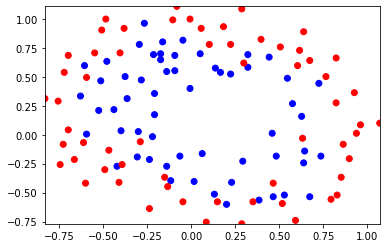

In [94]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [95]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (5,10,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [96]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate_init=0.01,
              max_iter=10000, solver='sgd')

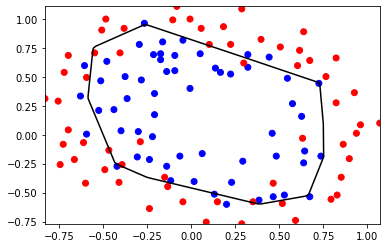

In [97]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [98]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576

In [99]:
clf.n_iter_

882

# Second task

In [100]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))


Training set: X=(100, 2), y=(100,)


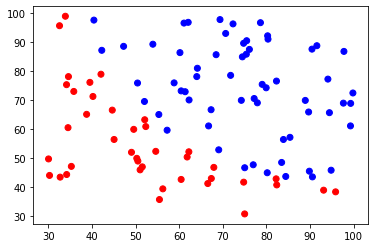

In [101]:
plot_data(X, Y)

In [102]:
cls = NeuralNet(normalize = True, learning_rate = 0.6, num_iter = 4000, hidden_layer_sizes=(100,), tol=1e-6)

0-th iteration: 0.6991296069519352
1000-th iteration: 0.6693015016227121
2000-th iteration: 0.4440232110053385
3000-th iteration: 0.22970861412903318


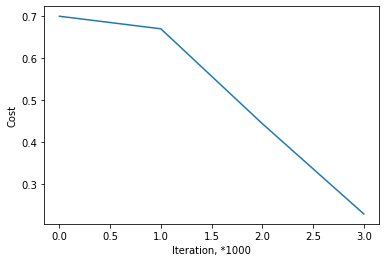

In [103]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [104]:

print(cls.parameters)

{'W_arr': [array([[ 2.07962943e+00,  1.83861286e+00],
       [ 2.79243766e+00,  2.45042632e+00],
       [ 6.83939091e-01,  6.26918914e-01],
       [-7.24597793e-01, -6.36344665e-01],
       [-3.02612014e+00, -2.68502888e+00],
       [-6.86464050e-01, -5.87591012e-01],
       [-1.83305884e-01, -1.52039265e-01],
       [ 5.70825869e-02,  3.12115797e-02],
       [ 1.90299955e+00,  1.67619389e+00],
       [-1.85910007e+00, -1.63576846e+00],
       [-8.21173251e-01, -6.98467306e-01],
       [ 2.91509459e-01,  2.60658724e-01],
       [ 2.01792821e+00,  1.80065527e+00],
       [-1.13624901e-01, -9.91734057e-02],
       [ 4.88046547e-02,  3.29253528e-02],
       [-8.95433813e-01, -7.80070575e-01],
       [ 9.64048890e-01,  8.60629579e-01],
       [-1.02299396e+00, -9.05339825e-01],
       [-8.41745260e-01, -7.42243411e-01],
       [ 5.14086705e-02,  3.83151351e-02],
       [ 2.62764866e+00,  2.31670644e+00],
       [ 5.63666763e-01,  5.06058990e-01],
       [-2.69522171e-01, -2.44909318e-01],


In [105]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[1.42735845e-01, 8.57264155e-01],
       [4.48581386e-04, 9.99551419e-01],
       [8.39205567e-02, 9.16079443e-01],
       [9.72993755e-01, 2.70062450e-02],
       [9.92579671e-01, 7.42032892e-03],
       [2.98774786e-02, 9.70122521e-01],
       [9.95078921e-01, 4.92107941e-03],
       [4.47633014e-01, 5.52366986e-01],
       [9.98149810e-01, 1.85018956e-03],
       [6.95868645e-01, 3.04131355e-01],
       [8.62259848e-01, 1.37740152e-01],
       [6.39508156e-02, 9.36049184e-01],
       [9.96288591e-01, 3.71140933e-03],
       [9.98893371e-01, 1.10662941e-03],
       [2.11616666e-01, 7.88383334e-01],
       [9.54369467e-01, 4.56305332e-02],
       [4.49329887e-01, 5.50670113e-01],
       [2.10222828e-01, 7.89777172e-01],
       [9.98120724e-01, 1.87927555e-03],
       [5.64979649e-01, 4.35020351e-01],
       [1.18123015e-01, 8.81876985e-01],
       [9.94044436e-01, 5.95556447e-03],
       [2.26785119e-02, 9.77321488e-01],
       [8.67783164e-04, 9.99132217e-01],
       [9.766513

In [106]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [107]:
accuracy_score(Y, Y_hat)

0.89

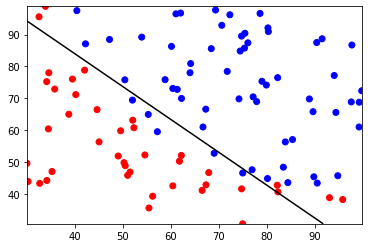

In [108]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [109]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (800,), max_iter = 10000, activation = 'tanh', solver = 'sgd', learning_rate_init = 0.0005, learning_rate = 'constant')


In [ ]:
clf.fit(X, Y)

In [ ]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [ ]:
accuracy_score(Y, clf.predict(X))